In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

In [ ]:
path = '/content/drive/MyDrive/XGBoost/train.csv'

data = pd.read_csv(path)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
X = data.drop('SalePrice',axis=1)
y = data['SalePrice']

X.head()
X.describe()
X.info()

In [ ]:
X_train_full,X_valid_full,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

In [ ]:
X_train_full['Street'].nunique()

2

In [ ]:
categorical_col=[col for col in X_train_full.columns if X_train_full[col].dtype=='O' and X_train_full[col].nunique()<10]
print(categorical_col)

numerical_col=[col for col in X_train_full.columns if X_train_full[col].dtype in ['float64','int64']]
print(numerical_col)

my_cols=categorical_col + numerical_col
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'P

In [ ]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
618,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
870,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
92,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
817,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
302,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
                                          ('impute',SimpleImputer(strategy='most_frequent')),
                                          ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
                                               ('num',numerical_transformer,numerical_col),
                                               ('cat',categorical_transformer,categorical_col)
])

eval_set_pipe = Pipeline(steps = [('preprocessor', preprocessor)])

In [ ]:
my_model = XGBRegressor(n_estimators=1000, early_stopping_rounds=20, eval_metric = "rmse", learning_rate=0.1, n_jobs=4)

In [ ]:
X_train_eval=X_train.copy()
X_train_eval = eval_set_pipe.fit_transform(X_train)
pd.DataFrame(X_train_eval,index=X_train.index)

In [ ]:
# Make a copy to avoid changing original data
X_valid_eval=X_valid.copy()
# fit transform X_valid.copy()
X_valid_eval = eval_set_pipe.transform (X_valid_eval)

pd.DataFrame(X_valid_eval, index=X_valid.index)

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
529,530.0,20.0,69.614017,32668.0,6.0,3.0,1957.0,1975.0,103.481067,1219.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
491,492.0,50.0,79.000000,9490.0,6.0,7.0,1941.0,1950.0,0.000000,403.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
459,460.0,50.0,69.614017,7015.0,5.0,4.0,1950.0,1950.0,161.000000,185.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
279,280.0,60.0,83.000000,10005.0,7.0,5.0,1977.0,1977.0,299.000000,392.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
655,656.0,160.0,21.000000,1680.0,6.0,5.0,1971.0,1971.0,381.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,327.0,120.0,32.000000,10846.0,8.0,5.0,1993.0,1993.0,0.000000,1619.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
440,441.0,20.0,105.000000,15431.0,10.0,5.0,2008.0,2008.0,200.000000,1767.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1387,1388.0,50.0,60.000000,8520.0,6.0,7.0,1916.0,1950.0,0.000000,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1323,1324.0,30.0,50.000000,5330.0,4.0,7.0,1940.0,1950.0,0.000000,280.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

records = []
mae_scores = []
# citys = ['新北市', '台北市', '桃園市', '台中市', '台南市', '高雄市', '新竹市', '新竹縣']
citys = ['新北市']
for city in citys:
    #read dataset according to citys
    x_train = pd.read_csv('/content/drive/MyDrive/XGBoost/data/train/x_train_%s.csv' % (city))
    y_train = pd.read_csv('/content/drive/MyDrive/XGBoost/data/train/y_train_%s.csv' % (city))
    x_test = pd.read_csv('/content/drive/MyDrive/XGBoost/data/test/x_test_%s.csv' % (city))
    y_test = pd.read_csv('/content/drive/MyDrive/XGBoost/data/test/y_test_%s.csv' % (city))
    #Without log1p and PCA, but price and peoples has been divided by 1,000.
    x_train_value = x_train.values
    x_test_value = x_test.values
    y_train_value = y_train.values
    y_test_value = y_test.values
    #transform to log1p form
    # y_train_value = np.log1p(y_train_value)
    # y_test_value = np.log1p(y_test_value)
    #PCA
    # pca = PCA(n_components=50)
    # pca_x_train = pca.fit_transform(x_train_value)
    # pca = PCA(n_components=50)
    # pca_x_test = pca.fit_transform(x_test_value)
    #build XGBoost model
    my_model = XGBRegressor(n_estimators=2000, 
                            objective='reg:squarederror',
                            max_depth=11,
                            subsample=0.8005630073716024,
                            gamma=0.9267584767684108,
                            colsample_bytree=0.9988015932047529,
                            early_stopping_rounds=20, 
                            min_child_weight=0.8572504467657722,
                            eval_metric = "mae", 
                            reg_lambda=0.6553015656015893,
                            reg_alpha=0.0,
                            scale_pos_weight=1,
                            verbosity=0,
                            learning_rate=0.00647631488262977,
                            n_jobs=4)
    #training XGBoost model
    my_model.fit(x_train_value, y_train_value, eval_set=[(x_test_value, y_test_value)])
    # my_model.fit(pca_x_train, y_train_value, eval_set=[(pca_x_test, y_test_value)])
    #make prediction on test dataset
    preds = my_model.predict(x_test_value)
    # preds = my_model.predict(pca_x_test)
    #transform back to original form
    # preds = np.expm1(preds)
    # y_test_value = np.expm1(y_test_value)
    #calculate the accuracy
    score = mean_absolute_error(y_test_value, preds)
    mae_scores.append(score)
    y_test_reshape = y_test_value.reshape(1, -1)[0]
    correct = 0
    for i in range(len(y_test_reshape)):
      if abs(y_test_reshape[i]-preds[i]) < y_test_reshape[i]*0.1:
        correct += 1

    print('City: {%s} Accuracy: {%f}' % (city, correct/len(y_test_reshape)))
    records.append(correct/len(y_test_reshape))

[0]	validation_0-mae:143.758
[1]	validation_0-mae:142.833
[2]	validation_0-mae:141.911
[3]	validation_0-mae:140.995
[4]	validation_0-mae:140.089
[5]	validation_0-mae:139.189
[6]	validation_0-mae:138.292
[7]	validation_0-mae:137.404
[8]	validation_0-mae:136.522
[9]	validation_0-mae:135.65
[10]	validation_0-mae:134.781
[11]	validation_0-mae:133.912
[12]	validation_0-mae:133.055
[13]	validation_0-mae:132.199
[14]	validation_0-mae:131.356
[15]	validation_0-mae:130.506
[16]	validation_0-mae:129.661
[17]	validation_0-mae:128.826
[18]	validation_0-mae:127.997
[19]	validation_0-mae:127.176
[20]	validation_0-mae:126.363
[21]	validation_0-mae:125.552
[22]	validation_0-mae:124.744
[23]	validation_0-mae:123.942
[24]	validation_0-mae:123.142
[25]	validation_0-mae:122.359
[26]	validation_0-mae:121.569
[27]	validation_0-mae:120.789
[28]	validation_0-mae:120.009
[29]	validation_0-mae:119.238
[30]	validation_0-mae:118.468
[31]	validation_0-mae:117.709
[32]	validation_0-mae:116.954
[33]	validation_0-mae

In [ ]:
for i in range(len(citys)):
    print('City: %s Accuracy: %f MAE: %f' % (citys[i], records[i], mae_scores[i]))

City: 新北市 Accuracy: 0.522346 MAE: 20.403037
City: 台北市 Accuracy: 0.382381 MAE: 43.015173
City: 桃園市 Accuracy: 0.463800 MAE: 17.556407
City: 台中市 Accuracy: 0.433063 MAE: 21.223014
City: 台南市 Accuracy: 0.362903 MAE: 34.554016
City: 高雄市 Accuracy: 0.454981 MAE: 15.856359
City: 新竹市 Accuracy: 0.344051 MAE: 24.206421
City: 新竹縣 Accuracy: 0.421409 MAE: 21.274101


In [7]:
for i in range(len(citys)):
    print('City: %s Accuracy: %f MAE: %f' % (citys[i], records[i], mae_scores[i]))

City: 新北市 Accuracy: 0.522346 MAE: 20.403037


In [ ]:
x_train = pd.read_csv('/content/drive/MyDrive/XGBoost/data/train/x_train_新北市.csv')
y_train = pd.read_csv('/content/drive/MyDrive/XGBoost/data/train/y_train_新北市.csv')
x_test = pd.read_csv('/content/drive/MyDrive/XGBoost/data/test/x_test_新北市.csv')
y_test = pd.read_csv('/content/drive/MyDrive/XGBoost/data/test/y_test_新北市.csv')

In [ ]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,165.659,183.559,802.0,3.0,0.0,127187.0,0.0,19.44,0.96,0.006
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.659,183.559,802.0,3.0,0.0,127187.0,0.0,19.44,0.96,0.006
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,165.659,183.559,802.0,3.0,0.0,127187.0,0.0,19.44,0.96,0.006
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.659,183.559,802.0,3.0,0.0,127187.0,0.0,19.44,0.96,0.006
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.659,183.559,802.0,3.0,0.0,127187.0,0.0,19.44,0.96,0.006


In [ ]:
x_train_value = x_train.values
x_test_value = x_test.values
y_train_value = y_train.values
y_test_value = y_test.values

In [ ]:
x_train_value.shape

(10997, 60)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=50)
pca_x_train = pca.fit_transform(x_train_value)

In [ ]:
pca = PCA(n_components=50)
pca_x_test = pca.fit_transform(x_test_value)

In [ ]:
# transform to log1p form
y_train_value = np.log1p(y_train_value)
y_test_value = np.log1p(y_test_value)

In [ ]:
my_model = XGBRegressor(n_estimators=2000, 
                        objective='reg:squarederror',
                        max_depth=11,
                        subsample=0.8005630073716024,
                        gamma=0.9267584767684108,
                        colsample_bytree=0.9988015932047529,
                        early_stopping_rounds=20, 
                        min_child_weight=0.8572504467657722,
                        eval_metric = "mae", 
                        reg_lambda=0.6553015656015893,
                        reg_alpha=0.0,
                        scale_pos_weight=1,
                        verbosity=0,
                        learning_rate=0.00647631488262977,
                        n_jobs=4)

In [ ]:
# my_model.fit(pca_x_train, y_train_value, eval_set=[(pca_x_test, y_test_value)])

In [ ]:
my_model.fit(x_train_value, y_train_value, eval_set=[(x_test_value, y_test_value)])

In [ ]:
# my_model.fit(X_train_eval, y_train, early_stopping_rounds=20, eval_metric = "mae", eval_set=[(X_valid_eval, y_test)])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
preds = my_model.predict(x_test_value)
# preds = my_model.predict(pca_x_test)

# Evaluate the model
score = mean_absolute_error(y_test_value, preds)
# score = mean_squared_error(y_test_value, preds)
print('MAE:', score)

MAE: 14.976519837516884


In [ ]:
# transform back to original form
preds = np.expm1(preds)
y_test_value = np.expm1(y_test_value)
y_test_reshape = y_test_value.reshape(1, -1)[0]

In [ ]:
y_test_reshape = y_test_value.reshape(1, -1)[0]

In [ ]:
correct = 0
for i in range(len(y_test_reshape)):
  if abs(y_test_reshape[i]-preds[i]) < y_test_reshape[i]*0.1:
    correct += 1

print('Accuracy: {%f}' % (correct/len(y_test_reshape)))

city:test Accuracy: {0.491389}


In [ ]:
correct = 0
for i in range(len(y_test_reshape)):
  if abs(y_test_reshape[i]-preds[i]) < y_test_reshape[i]*0.1:
    correct += 1

correct/len(y_test_reshape)

0.4288205798997166

In [ ]:
correct/len(y_test_reshape)

0.4307826466099847

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
thresholds = np.sort(my_model.feature_importances_)

In [ ]:
thresholds

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00096725, 0.00120976, 0.00141146, 0.00153553, 0.00174279,
       0.00219257, 0.00278997, 0.00299182, 0.00315058, 0.00316821,
       0.00319367, 0.00331039, 0.00361026, 0.00362186, 0.00363947,
       0.00375252, 0.0042399 , 0.00448682, 0.00508505, 0.00582785,
       0.00612102, 0.00616128, 0.00644571, 0.0064579 , 0.00650863,
       0.00820351, 0.00884514, 0.00937902, 0.01021893, 0.01024646,
       0.01123325, 0.01198693, 0.01211729, 0.01591315, 0.02057658,
       0.02286097, 0.02625358, 0.02814578, 0.03095951, 0.03389055,
       0.04083505, 0.04112884, 0.0438833 , 0.05073756, 0.06191845,
       0.06647307, 0.07073974, 0.07252684, 0.07803592, 0.11926831],
      dtype=float32)

In [ ]:
selection = SelectFromModel(my_model, threshold=thresholds[10], prefit=True)

In [ ]:
feature_idx = selection.get_support()

In [ ]:
feature_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True, False, False, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True])

In [ ]:
selected_train = selection.transform(x_train.values)
selected_test = selection.transform(x_test.values)

In [ ]:
selected_train.shape

(10997, 50)

In [ ]:
my_model.fit(selected_train, y_train.values, 
             eval_set=[(selected_test, y_test.values)])

In [ ]:
from sklearn.metrics import mean_absolute_error
preds = my_model.predict(x_test.values[:, feature_idx])

# Evaluate the model
score = mean_absolute_error(y_test.values, preds)
print('MAE:', score)

MAE: 14.934761970365336


In [ ]:
correct = 0
for i in range(len(y_test_reshape)):
  if abs(y_test_reshape[i]-preds[i]) < y_test_reshape[i]*0.1:
    correct += 1

In [ ]:
correct/len(y_test_reshape)

0.49378678875081755

In [ ]:
output = pd.DataFrame({'PredPrice': preds, 'Price_per-m2': y_test_reshape})
output.to_csv('/content/HousePrice.csv', index=False)

In [ ]:
X_test_full=pd.read_csv('/content/drive/MyDrive/XGBoost/test.csv')
X_test=X_test_full[my_cols].copy()

X_test_eval=X_test.copy()
X_test_eval = eval_set_pipe.transform (X_test_eval)
pd.DataFrame(X_test_eval, index=X_test_full.index)

pred_test=my_model.predict(X_test_eval)

In [ ]:
output = pd.DataFrame({'Id': X_test_full['Id'],
                       'PredPrice': pred_test})
output.to_csv('/content/submission.csv', index=False)

In [ ]:
my_model.feature_importances_

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 5.1 MB/s 


In [4]:
import shap

In [ ]:
x_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,74.57,25.02,2.0,148.24,0.0,8.61
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,162.77,83.56,5.0,166.51,0.0,3.74
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,54.83,51.84,1.0,75.04,0.0,5.59
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,79.02,39.67,2.0,188.43,0.0,6.69
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,278.56,165.51,10.0,278.56,0.0,0.00


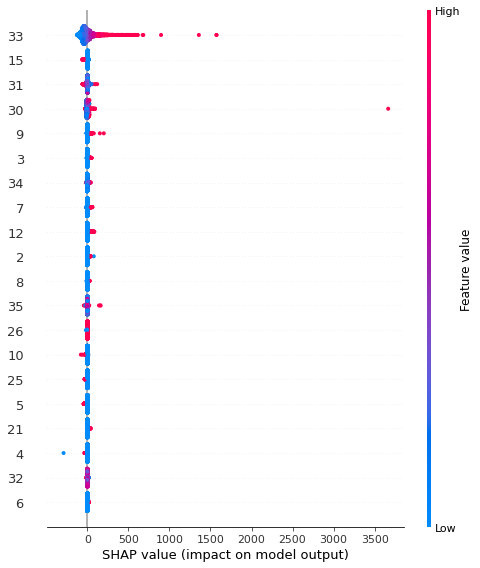

In [8]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(x_test)
# shap.summary_plot(shap_values, x_test, plot_type="bar")
shap.summary_plot(shap_values, x_test)